In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


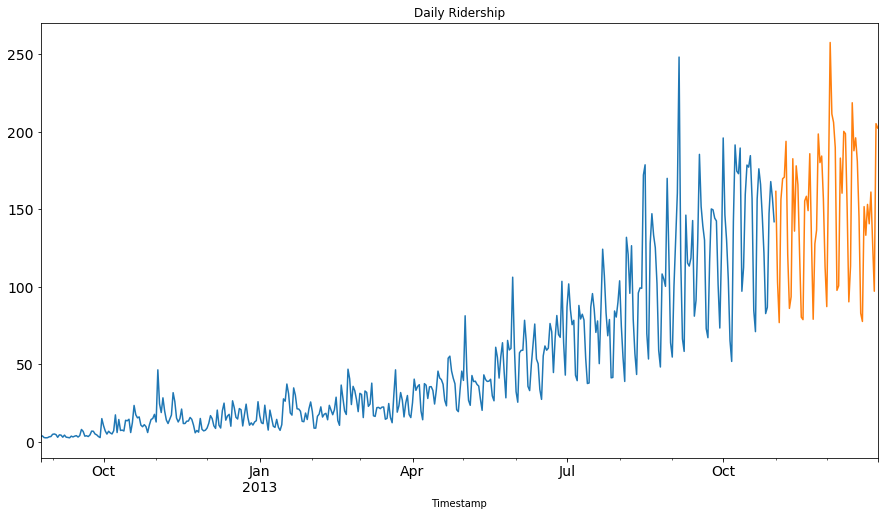

In [2]:
# 取出2018年8月-2013年10月数据用作训练数据，2013年11月-2013年12月数据用作测试数据
df = pd.read_csv('train.csv', nrows=11856)
train = df[:10392]
test = df[10392:]

# 进行重采样，将时间频率降为天，数值取平均数
df['Timestamp'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.index = df['Timestamp']
df = df.resample('D').mean()

train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
train.index = train['Timestamp']
train = train.resample('D').mean()

test['Timestamp'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
test.index = test['Timestamp']
test = test.resample('D').mean()

# 数据可视化，数据在一段时间内的变化情况
train['Count'].plot(figsize=(15, 8), title='Daily Ridership', fontsize=14)
test['Count'].plot(figsize=(15, 8), title='Daily Ridership', fontsize=14)

### <font color=blue>方法1：朴素法</font>

直接取前一天的数据预测后一天的数据

Text(0.5,1,'Naive Forecast')

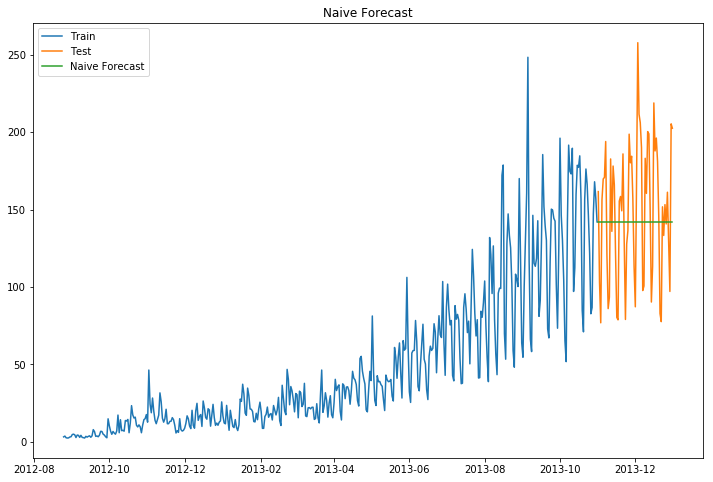

In [3]:
dd = np.asarray(train['Count']) # 浅拷贝
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1] # 训练数据集最后一条数据

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')

In [4]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Count'], y_hat['naive'])) # 计算均方根误差
print('朴素法均方误根差为：',rmse)

朴素法均方误根差为： 43.91640614391676


### <font color=blue>方法2：简单平均法</font>

取前几天数据的平均值预测

Text(0.5,1,'Average Forecast')

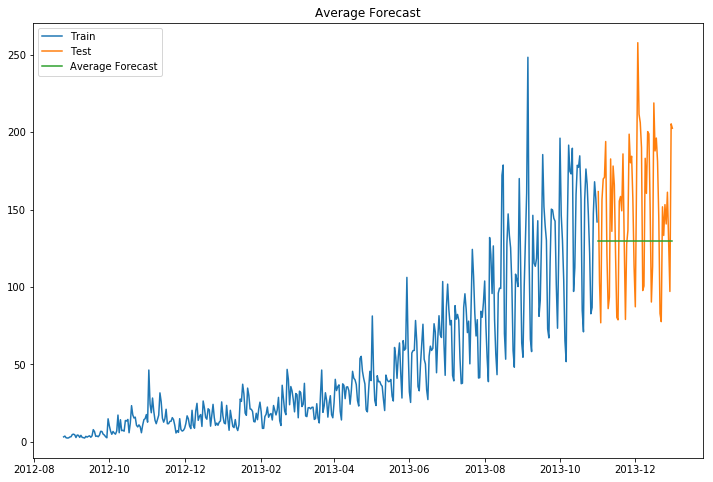

In [5]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'][-7:].mean() # 取最后七天数据平均值预测

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(test.index, y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Average Forecast')

In [6]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['avg_forecast']))
print('简单平均法均方根误差为：', rmse)

简单平均法均方根误差为： 47.67423353762358


### <font color=blue>方法3：移动平均法</font>

根据前p个数的平均值预测下一个数

Text(0.5,1,'Moving Average Forecas')

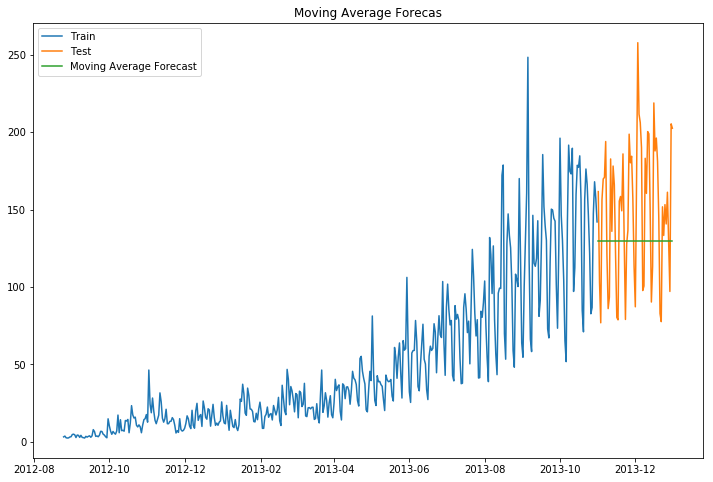

In [7]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(7).mean().iloc[-1] # p值取7

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(test.index, y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecas')

In [8]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['moving_avg_forecast']))
print('移动平均法均方根误差为：', rmse)

移动平均法均方根误差为： 47.67423353762362


这里其实应该取训练集最后7天数据均值作为测试集第一条数据，训练集后6条数据加上测试集预测第一条数据作为均值，以此类推

Text(0.5,1,'Moving Average Forecas')

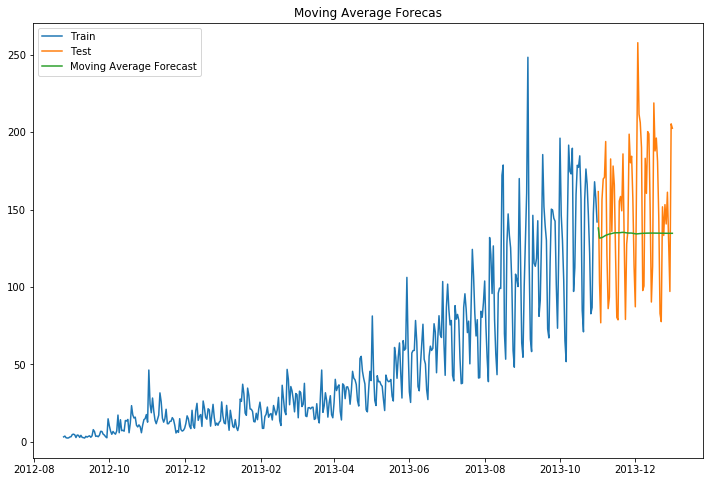

In [9]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = None
y_hat_avg['moving_avg_forecast'].iloc[0] = train['Count'].rolling(30).mean().iloc[-1] # p值取30
# 预测前30个数
for i in range(1, 30):
    y_hat_avg['moving_avg_forecast'].iloc[i] = (train['Count'].rolling(30).mean()[-(30-i):].sum()+
                                                y_hat_avg['moving_avg_forecast'][:i].sum())/30
# 预测30个之后的数
for i in range(30, len(test)):
    y_hat_avg['moving_avg_forecast'].iloc[i] = y_hat_avg['moving_avg_forecast'][i-30:i].sum()/30

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(test.index, y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecas')

In [10]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['moving_avg_forecast']))
print('移动平均法均方根误差为：', rmse)

移动平均法均方根误差为： 45.687429236844885


对比简单平均法提升并不明显，这里有两种方法提高预测准确率  
1、调整p值  
2、为每个日期的数据赋予不同权重

### <font color=blue>方法4：简单指数平滑法</font>

对时间点T+1的单步预测值是时序的所有观测值的加权平均数。权重下降的速率由参数α控制

Text(0.5,1,'SimpleExpSmoothing')

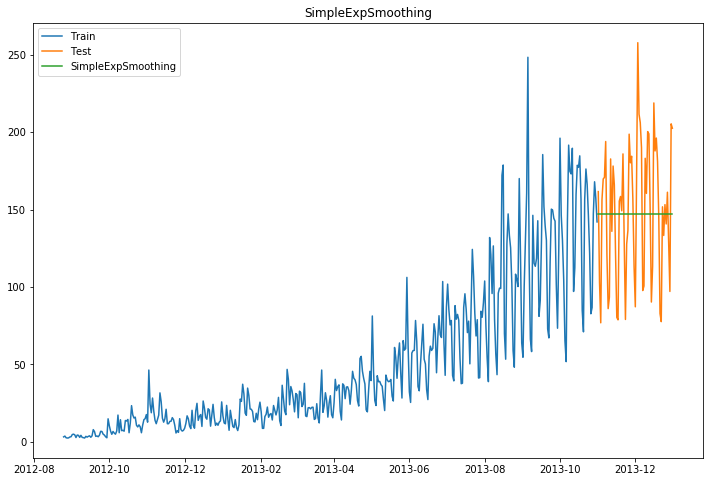

In [37]:
from statsmodels.tsa.api import SimpleExpSmoothing

y_hat_avg = test.copy()
fit = SimpleExpSmoothing(train['Count']).fit(smoothing_level=0.6, optimized=False) # α=0.6
y_hat_avg['SES'] = fit.forecast(len(test))

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['SES'], label='SimpleExpSmoothing')
plt.legend(loc='best')
plt.title('SimpleExpSmoothing')

In [29]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['SES']))
print('简单指数平滑法均方根误差：', rmse)

简单指数平滑法均方根误差： 43.357625225228155


### <font color=blue>方法5：霍尔特(Holt)线性趋势法</font>

每个时序数据集可以分解为相应的几个部分：趋势（Trend），季节性(Seasonal)和残差(Residual)。任何呈现某种趋势的数据集都可以用霍尔特线性趋势法用于预测。

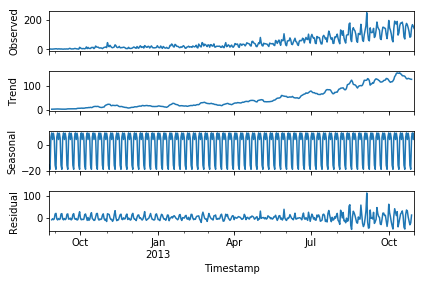

In [26]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train['Count']).plot()
result = sm.tsa.stattools.adfuller(train['Count'])

从图中可以看到数据呈上升趋势，可以使用霍尔特线性趋势法预测数据

Text(0.5,1,'Holt Linear')

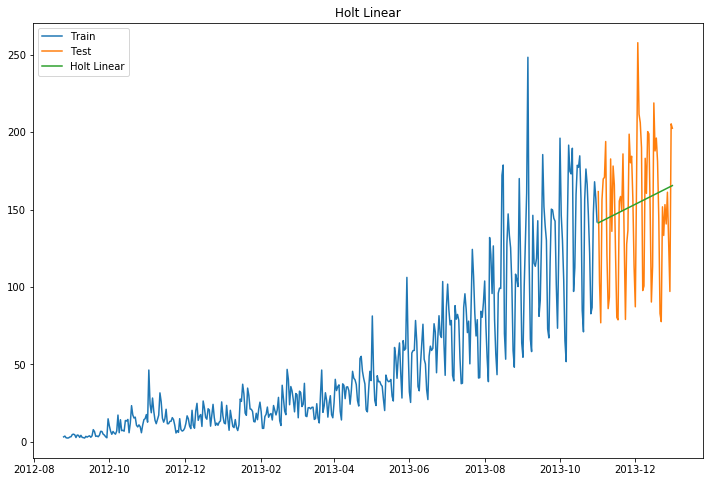

In [40]:
from statsmodels.tsa.api import Holt

y_hat_avg = test.copy()

fit = Holt(train['Count']).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_avg['Holt_linear'] = fit.forecast(len(test))

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_linear'], label='Holt Linear')
plt.legend(loc='best')
plt.title('Holt Linear')

In [34]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_linear']))
print('霍尔特线性趋势法：', rmse)

霍尔特线性趋势法： 43.056259611507286


### <font color=blue>方法6：Holt-Winters季节性预测模型</font>

三次平滑预测，水平函数，趋势函数，季节分量

Text(0.5,1,'Holt Winter')

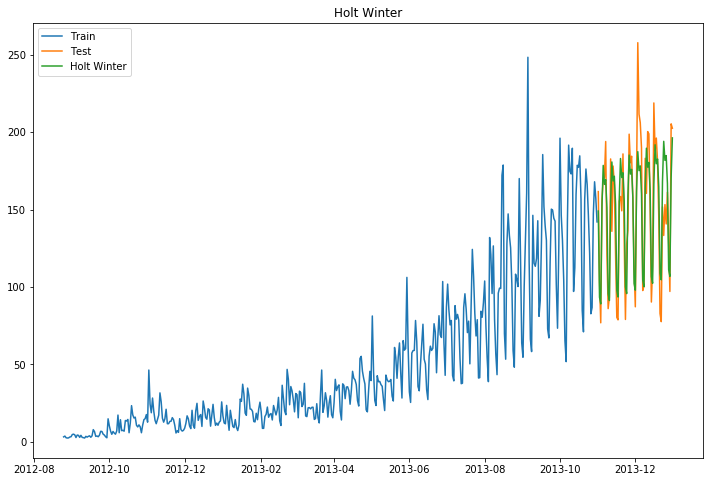

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test.copy()
fit = ExponentialSmoothing(train['Count'], seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit.forecast(len(test))

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['Holt_Winter'], label='Holt Winter')
plt.legend(loc='best')
plt.title('Holt Winter')

In [42]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_Winter']))
print('Holt-Winters季节性预测模型：', rmse)

Holt-Winters季节性预测模型： 23.961492566159794


### <font color=blue>方法7：自回归移动平均模型（ARIMA）</font>

指数平滑模型都是基于数据中的趋势和季节性的描述，而自回归移动平均模型的目标是描述数据中彼此之间的关系。ARIMA的一个优化版就是季节性ARIMA。它像Holt-Winters季节性预测模型一样，也把数据集的季节性考虑在内。

/Users/wangyutian/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'SARIMA')

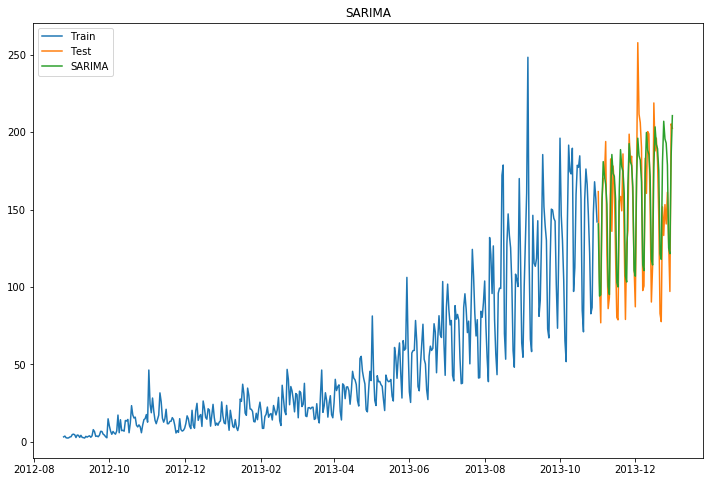

In [44]:
import statsmodels.api as sm

y_hat_avg = test.copy()
fit = sm.tsa.statespace.SARIMAX(train['Count'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = fit.predict(start="2013-11-1", end="2013-12-31", dynamic=True)

plt.figure(figsize=(12, 8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index, test['Count'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.title('SARIMA')

In [45]:
rmse = np.sqrt(mean_squared_error(test['Count'], y_hat_avg['SARIMA']))
print('自回归移动平均模型（ARIMA）：', rmse)

自回归移动平均模型（ARIMA）： 26.067414666253228
